In [1]:
# you might need this if you are on a mac
import pytensor
pytensor.config.cxx = "/usr/bin/clang++"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import cm
import pymc as pm
import arviz as az
import seaborn as sns

# Exercise session 4: Normal-normal

* Derive a normal-normal probabilistic model for the heigth of the Swiss population compatible with the following prior assumptions:

1. The mean height of the population lies with 99% probability between 160 and 190 cm
2. The heigth of each individual lies with 99% probability between 100 and 250 cm

Treat the population mean *and* standard deviation as random variables.


Two Swiss individuals are observed, their heighs are 168, 178 cm

In [3]:
y = np.array([168, 178])

The probabilistic model is:

\begin{align}
 \mu    & \sim N(\mu_\mu, \sigma_\mu)\\
 \sigma & \sim \textrm{Half-Normal}(\xi)\\
 \vec{y}|\mu, \sigma & \sim N(\mu, \sigma)
\end{align}


The *hyper-parameters* of the probabilistic models are chosen in accordance with the prior assumptions as follows:
 - The prior mean of the population mean $\mu_\mu$ could be set to (190 + 160)/2 = 175 cm. <br/>
 - The prior standard deviation of the population mean $\sigma_\mu$ could be set to (190 -175)/3 = 5 cm. <br/>
 - A plausible value for the standard deviation $\sigma$ of the individuals within the population is (250-100)/6 = 25.
A half-normal distribution with scale parameter $\xi=38$ has median slightly over 25. 

In [4]:
 pd.DataFrame(stats.halfnorm.rvs(size=1000000, scale=38)).median() # approx 25

0    25.542627
dtype: float64

Then, we can set $\xi=38$.

* Implement the model in pymc

In [5]:
mu_mu = 175 # mean of the prior mean's distribution
sigma_mu = 5 # standard deviation of the prior mean's distribution 
xi = 38 # scale parameter of the prior population's standard deviation
#pd.DataFrame(stats.halfnorm.rvs(size=1000, scale=38)).median() # approx 24

In [6]:
with pm.Model() as model_height:

    # prior distribution
    mu = pm.Normal('mu', mu_mu, sigma_mu) # prior meam
    sigma = pm.HalfNormal('sigma', sigma=xi) # prior std

    # observation model (likelihood)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    trace_height = pm.sample(draws=2000, tune=2000) # defaults: 1000, 1000

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.


In [7]:
#pm.model_to_graphviz(model_height) # pip install graphviz, apt-get install graphviz (on ubuntu)

In [8]:
with model_height:
    display(az.summary(trace_height))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,174.433,4.165,166.834,182.572,0.064,0.045,4379.0,4126.0,1.0
sigma,14.401,11.616,2.698,35.396,0.184,0.130,4224.0,4599.0,1.0


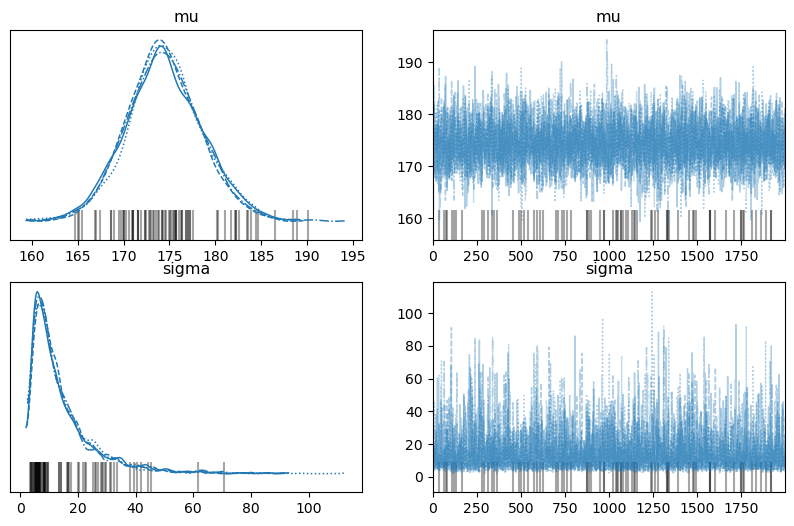

In [9]:
with model_height:
    az.plot_trace(trace_height, figsize=(10, 6));

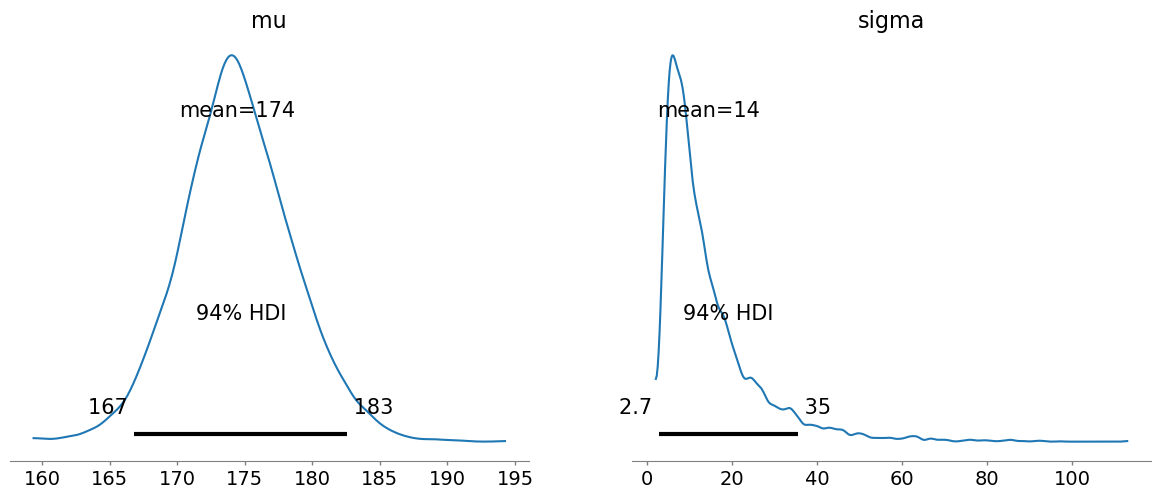

In [10]:
with model_height:
    az.plot_posterior(trace_height);

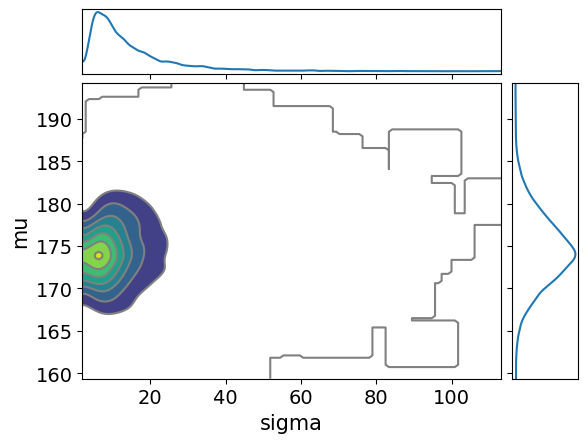

In [11]:
with model_height:
    az.plot_pair(trace_height,
                 kind="kde", # scatter, hexbin, kde
                 var_names=["sigma", "mu"], 
                 marginals=True);

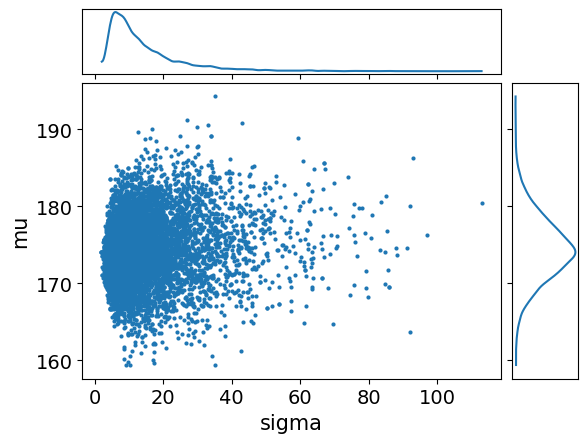

In [12]:
with model_height:
    az.plot_pair(trace_height,
                 kind="scatter", 
                 var_names=["sigma", "mu"], 
                 marginals=True);

* Visualize the prior density $f_{\rm prior}(\mu, \sigma)$ in 2D

In [13]:
prior_mu = stats.norm(loc=mu_mu, scale=sigma_mu)
prior_sigma = stats.halfnorm(scale=xi)

def prior_pdf_fun(mu, sigma):
    return prior_mu.pdf(mu)*prior_sigma.pdf(sigma)

mu_vec = np.linspace(145, 205, 100) # min, max points
sigma_vec = np.linspace(0.01, 100, 120) # min, max points
prior_pdf_mat = np.zeros((len(mu_vec), len(sigma_vec))) 


for mu_idx, mu_val in enumerate(mu_vec):
    for sigma_idx, sigma_val in enumerate(sigma_vec):
        prior_pdf_mat[mu_idx, sigma_idx] = prior_pdf_fun(mu_val, sigma_val) #prior_mu.pdf(mu_val)*prior_sigma.pdf(sigma_val)

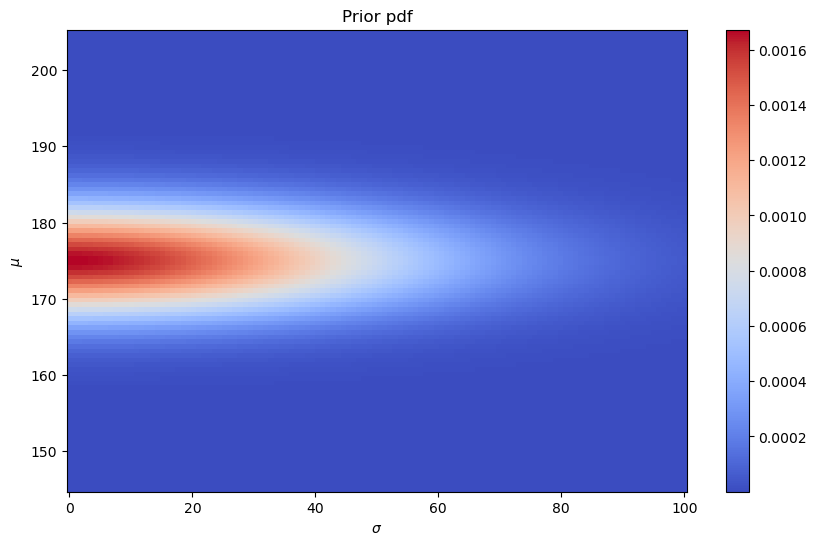

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(sigma_vec, mu_vec, prior_pdf_mat, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax)
ax.set_title(f"Prior pdf")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\mu$");

* Obtain a gridding approximation of the posterior $f(\mu, \sigma | \vec{y})$ and visualize it in 2D.

As always, the posterior is proportional to the product prior $\times$ likelihood:

$$f(\mu, \sigma | \vec{y}) \propto f_{\rm prior}(\mu, \sigma)f(\vec{y} | \mu, \sigma)$$ 

Gridding, aka brute-forcing, consists in computing this product on a dense grid, and then (approximately) normalizing the result so that it integrates to 1.

In [15]:
np.prod(stats.norm.pdf([170, 177], loc=168, scale=2))

9.668993540410832e-07

In [16]:
def lik_fun(mu, sigma, observed=y):
    return np.prod(stats.norm.pdf(observed, loc=mu, scale=sigma))

dmu = np.diff(mu_vec)[0]
dsigma = np.diff(sigma_vec)[0]
post_pdf_mat = np.zeros((len(mu_vec), len(sigma_vec))) 

for mu_idx, mu_val in enumerate(mu_vec):
    for sigma_idx, sigma_val in enumerate(sigma_vec):
        post_pdf_mat[mu_idx, sigma_idx] = prior_pdf_fun(mu_val, sigma_val) * \
             lik_fun(mu_val, sigma_val, observed=y)
        #prior_f = prior_mu.pdf(mu_val) * prior_sigma.pdf(sigma_val)
        #lik = np.prod(stats.norm.pdf(y, loc=mu_val, scale=sigma_val))
        #post_pdf_mat[mu_idx, sigma_idx] = prior_f * lik

post_pdf_mat = post_pdf_mat/(np.sum(post_pdf_mat)*dmu*dsigma) # normalization


np.sum(post_pdf_mat)*dmu*dsigma

1.0000000000000002

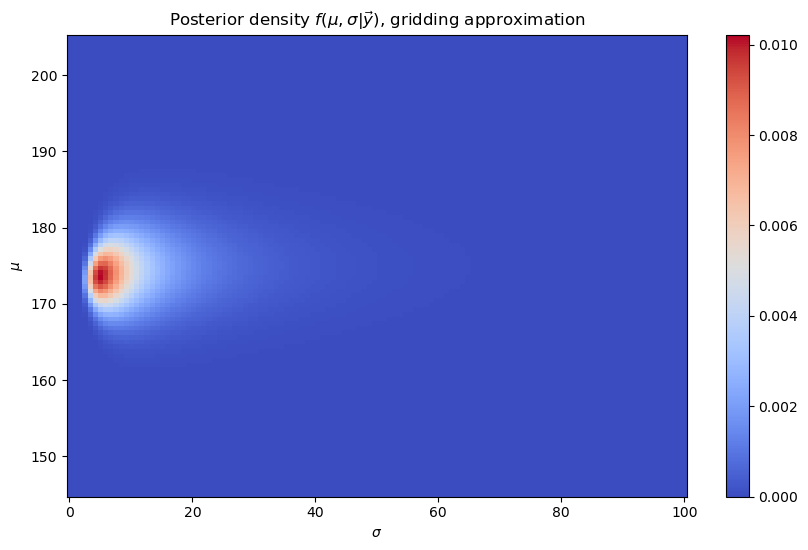

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(sigma_vec, mu_vec, post_pdf_mat, cmap=cm.coolwarm, shading='auto')
fig.colorbar(c, ax=ax)
ax.set_title(r"Posterior density $f(\mu, \sigma | \vec{y})$, gridding approximation")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\mu$");

The gridding posterior may be compared with the MC samples from pymc

/var/folders/w7/h67z1rn941j1p0m51k08d9xc0000gp/T/ipykernel_19799/292797033.py:5: UserWarning: Adding colorbar to a different Figure <Figure size 1000x600 with 2 Axes> than <Figure size 1000x600 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(c, ax=ax)


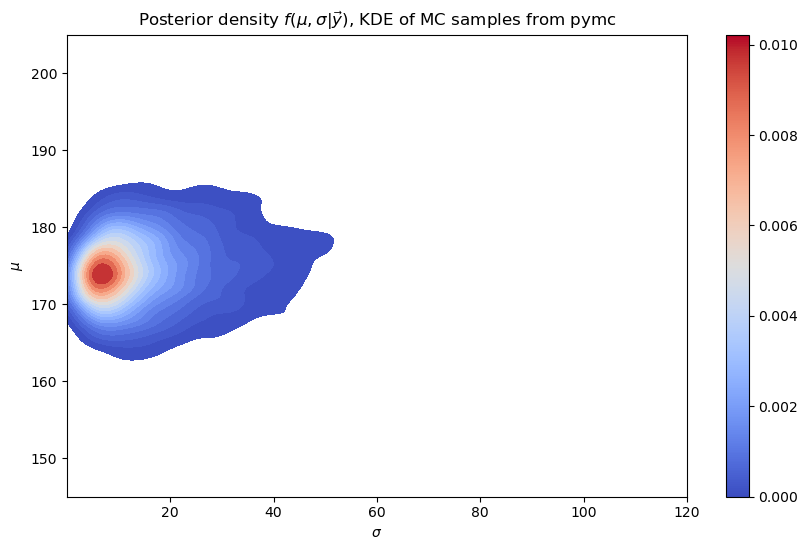

In [18]:
post_samples = az.extract(trace_height.posterior) #az.extract_dataset(trace_height.posterior)
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(x=post_samples.sigma.values, y=post_samples.mu.values,
            fill=True, cmap=cm.coolwarm, levels=20)
fig.colorbar(c, ax=ax)
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\mu$")
ax.set_xlim([0.01, 120])
ax.set_ylim([145, 205])
plt.title(r"Posterior density $f(\mu, \sigma | \vec{y})$, KDE of MC samples from pymc");

There seems to be an excellent match!

* Obtain a gridding approximation of the posterior $f(\mu, \sigma | \vec{y})$ using a log-domain implementation. Visualize the result in 2D.

In [19]:
def post_logpdf_fun(mu, sigma, observed=y):
    pass

# TODO

* What happens to the two gridding approximations (basic and in log domain) if the observation is `y_long` defined below?

In [20]:
y_long = np.repeat(y, 200) # A much longer observation. 

In [21]:
# TODO repeat gridding with the new observation y_long and discuss the results

* Obtain a sample-based approximation of the posterior implementing Metropolis from scratch. Visualize the results.

In [22]:
def p_ratio_fun(mu_propose, sigma_propose, mu_previous, sigma_previous):
    log_p_propose = post_logpdf_fun(mu_propose, sigma_propose, observed=y)
    log_p_previous = post_logpdf_fun(mu_previous, sigma_previous, observed=y)
    log_p_ratio = log_p_propose - log_p_previous 
    p_ratio = np.exp(log_p_ratio)
    return p_ratio

In [23]:
draws = 4_000 # number of Metropolis draws
tune = 1_000 # tuning samples to be discarded
mu_0 = 175.0 # initial value for alpha
sigma_0 = 10.0 # initial value for alpha

sigma_prop_mu = 2.0 # standard deviation of the proposal for mu
sigma_prop_sigma = 5.0 # standard deviation of the proposal for sigma

N = draws + tune # total number of Metropolis iterations to be run

# TODO complete Metropolis, generate relevant statistics and plots

* Compare the solutions obtained with the different techniques (gridding, metropolis, pymc).